In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

In [ ]:
#nvidia prices (1 year) into Data Frame
nvidia = yf.Tickers('NVDA')
nhist = nvidia.history(period='3y')

#Take only date, close, vol columns
nhist = nhist.drop(columns=['Stock Splits', 'Dividends', 'High', 'Low', 'Open'])

dev = np.std(nhist)

#find correlation between volumne and closing price for Nvidia
corr = nhist[['Close', 'Volume']].corr()
corr = corr.iloc[1, 0]
corr

[*********************100%***********************]  1 of 1 completed
C:\Users\stanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:4109: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


np.float64(-0.5543313548373848)

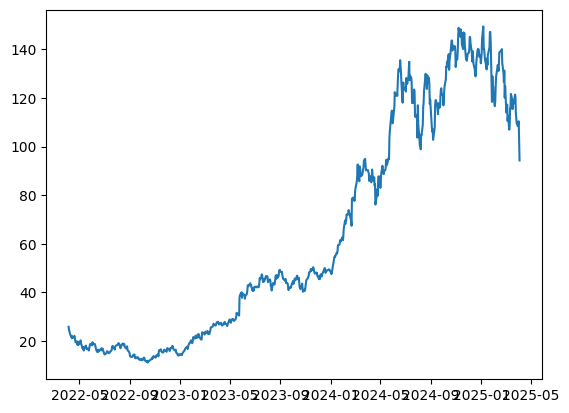

In [86]:
#nvidia price over time
plt.plot(nhist['Close'])

    


In [164]:
nPrice3mo = nvidia.history(period='3mo', interval='1mo')
nvda3mo = yf.Ticker('NVDA').get_recommendations()
nvda3mo = nvda3mo.drop(3)

mereg1 = nPrice3mo.reset_index()
mereg2 = nvda3mo.reset_index()

merged_nvda = pd.concat([mereg1, mereg2], axis=1)
merged_nvda = merged_nvda.drop(index={2})
merged_nvda

[*********************100%***********************]  1 of 1 completed


,"(Date, )","(Close, NVDA)","(Dividends, NVDA)","(High, NVDA)","(Low, NVDA)","(Open, NVDA)","(Stock Splits, NVDA)","(Volume, NVDA)",index,period,strongBuy,buy,hold,sell,strongSell
0,2025-02-01,124.908508,0.00,143.426809,112.999608,114.739446,0.0,4755230400,0,0m,11,45,6,0,0
1,2025-03-01,108.370033,0.01,123.688625,103.640472,123.498647,0.0,6177950300,1,-1m,11,46,5,0,0


In [137]:
nvda3mo

,period,strongBuy,buy,hold,sell,strongSell
0,0m,11,45,6,0,0
1,-1m,11,46,5,0,0
2,-2m,11,46,5,0,0
3,-3m,12,47,4,0,0


{'id': 'us',
 'name': 'U.S. markets',
 'status': 'closed',
 'yfit_market_id': 'us_market',
 'close': datetime.datetime(2025, 4, 4, 20, 0, tzinfo=datetime.timezone.utc),
 'message': 'U.S. markets closed',
 'open': datetime.datetime(2025, 4, 4, 13, 30, tzinfo=datetime.timezone.utc),
 'yfit_market_status': 'YFT_MARKET_CLOSED',
 'timezone': {'dst': 'true',
  'gmtoffset': '-14400',
  'short': 'EDT',
  '$text': 'America/New_York'},
 'tz': datetime.timezone(datetime.timedelta(days=-1, seconds=34560), 'EDT')}

In [126]:
#FOR FUN 

#take 1 year of nvidia stock data
nvdaShrt = yf.Ticker('NVDA')
nvdaShrt = nvdaShrt.history(period='1y')
nvdaShrt = nvdaShrt.drop(columns=['Dividends', 'Stock Splits', 'High', 'Low'])
nvdaShrt

#make a new column that states the change in price of 1 day before
increase = ['N/A']
for i in range(1, len(nvdaShrt['Open'])):
    increase.append(float(nvdaShrt.iloc[i-1, 0] - nvdaShrt.iloc[i-1, 1]))
nvdaShrt['prevChange'] = increase


#add 5-day simple moving average
sms = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A']
for i in range(5, len(nvdaShrt['Open'])):
    sms.append(np.average(nvdaShrt.iloc[i-4:i+1, 1]))
nvdaShrt['sms'] = sms


#determine if today closed higher than yesterday (1 = yes, 0 = no)
changed = ['N/A']
for i in range(1, len(nvdaShrt['Open'])):
    if nvdaShrt.iloc[i, 1] > nvdaShrt.iloc[i-1, 1]:
        changed.append(1)
    else:
        changed.append(0)
nvdaShrt['Changed'] = changed

#remove first 5
nvdaShrt = nvdaShrt.iloc[5:, :]

#turn all values in nvidia data frame to numbers
nvdaShrt = nvdaShrt.apply(pd.to_numeric, errors='coerce')

#assess correlation between open,close,volume,change in price in prev day, and whether or not price went up from yesterday
nvdaCorr = nvdaShrt.corr() 
#almost no correlation between the change in price of previous day to the price direction in the present day
nvdaCorr



,Open,Close,Volume,prevChange,sms,Changed
Open,1.000000,0.979966,-0.570078,-0.053415,0.973035,-0.053172
Close,0.979966,1.000000,-0.605417,-0.023287,0.963717,0.074795
Volume,-0.570078,-0.605417,1.000000,0.078254,-0.556378,-0.103541
prevChange,-0.053415,-0.023287,0.078254,1.000000,0.067326,0.097095
sms,0.973035,0.963717,-0.556378,0.067326,1.000000,-0.069890
Changed,-0.053172,0.074795,-0.103541,0.097095,-0.069890,1.000000


<Axes: >

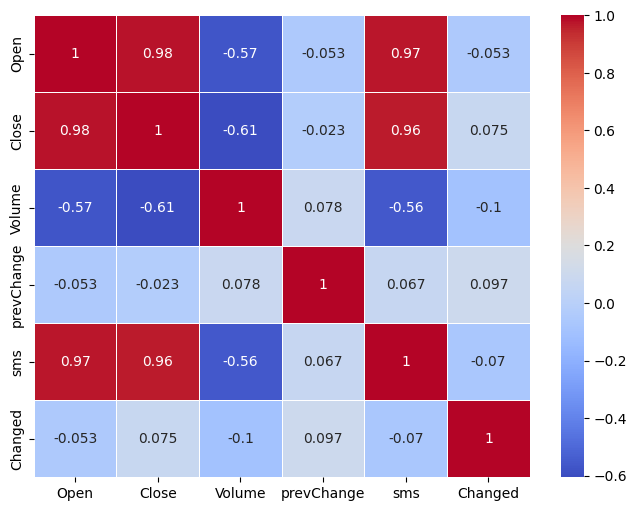

In [127]:
#Create a correlation heatmap for nvidia 
plt.figure(figsize=(8, 6))
sns.heatmap(nvdaCorr, annot=True, cmap='coolwarm', linewidths=0.5)